# University of Michigan 
# Master of Applied Data Science
### SIAD 699: Capstone
Team: James Yoon (jamyoon), Mario Feliciano (felicma), and James Tuccori (jtuccori)

Date: April 2023
____
# Social Media Sentiment & Predicting Trading Signals 

##### In this notebook, we add financials indicatiors and basic binary increase or decreasing indicators as features. We then run all the 177 features with 25,503 data points through a stacking model taking the top 4 probablistic models GBC, LR, LDA, ADA, and feeding then to an GBC model as a final model.

##### The output of the notebook is the prediction of the model for the 7,340 testing data points, which will be used in Step 5 back testing.  StackingPrediction_LR_ABC_LDA_GBC_to_GBC.csv

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from adspy_shared_utilities import plot_class_regions_for_classifier
from adspy_shared_utilities import plot_decision_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from adspy_shared_utilities import plot_decision_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
import pickle
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from finta import TA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers, metrics
import glob
import os

Add new features for the financial indifcators from finta library. Also importing the Traing Data below from Step 2. Creating an expotential smoothing to help reduce significant variance in the close data. Then creating binary indicators of the columns and financial features to use as new features. 

In [5]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']
# Df_hourly_merge = pd.read_csv('assets/PCHourly2019202_ActualLabel.csv')
Df_hourly_merge = pd.read_csv('assets/MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv')

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

Indicatordata = _exponential_smooth(Df_hourly_merge[['Close', 'Open','High','Low','Volume']], 0.65)
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

Indicatordatafinal = _get_indicator_data(Indicatordata)

Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
Df_hourly_merge2 = pd.merge(Df_hourly_merge, Indicatordatafinal, left_index=True, right_index=True)

Df_hourly_merge2 = Df_hourly_merge2.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)




def binary(value):
  if value > 0:
    return 1
  else:
    return 0

columns = ['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
       'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
       'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
       'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']


for column in columns: 
    Df_hourly_merge2['Binary{}'.format(column)]  = (Df_hourly_merge2[column] - Df_hourly_merge2[column].shift(1)).apply(binary)
    

In [6]:
len(Df_hourly_merge2)

25503

In [7]:
Df_hourly_merge2

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,BinaryROC,BinaryOBV,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5
0,6.517857,1.276786,10592.354167,1652.068452,45.605159,9.071429,0.124241,0.264455,3.275000,0.866089,...,0,0,0,0,0,0,0,0,0,0
1,2.685230,0.479419,14341.610169,1852.799031,74.444302,3.644068,0.067950,0.097316,3.342105,0.325240,...,0,0,0,0,0,0,1,1,1,1
2,2.138107,0.670077,21769.074169,2449.731458,68.571009,3.478261,0.120056,0.144203,6.120000,0.882520,...,0,0,0,0,0,0,0,0,0,0
3,1.916462,0.670762,36958.090909,2790.968059,100.500076,3.257985,0.143717,0.110483,5.964286,0.658951,...,0,0,0,0,0,0,0,0,0,0
4,4.339394,0.921212,13345.724242,3208.639394,66.105667,6.181818,0.136780,0.199699,4.607143,0.920041,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25498,5.783333,0.659524,12129.000000,1975.276190,108.150291,7.102381,0.077630,0.078660,3.022222,0.237728,...,0,0,1,1,0,1,0,0,0,0
25499,3.011905,0.392857,14180.595238,1765.121429,31.755382,3.797619,0.095683,0.135134,4.277778,0.578073,...,0,0,0,1,0,1,0,0,0,0
25500,14.400000,2.407143,16161.992857,2084.061905,182.260151,19.214286,0.082271,0.107210,3.648649,0.391172,...,0,0,0,0,1,0,0,0,0,0
25501,21.570806,3.270153,11254.296296,1814.954248,428.484448,28.111111,0.070485,0.165014,1.887324,0.311435,...,0,1,0,0,1,0,1,1,1,1


In [8]:
Df_hourly_merge2.columns.values

array(['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
       'JMJ_5HMoving_averages', 'Actual_Label',
       'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'Mkt Sentiment', 'Crypto Sentiment',
       'Historically Optimal SMA(s-t)', 'Historically Optimal SMA(l-t)',
       'Historically Optimal WMA(s-t)', 'Historically Optimal WMA(l-t)',
       'Historically Optimal EMA(s-t)', 'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',


#### Identifying what exactly are the features and the label

In [9]:
%%time
data = Df_hourly_merge2
data = data.dropna()

feature_names_JMJ = ['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
        'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'JMJ_5HMoving_averages', 'Mkt Sentiment',
       'Crypto Sentiment', 'Historically Optimal SMA(s-t)',
       'Historically Optimal SMA(l-t)', 'Historically Optimal WMA(s-t)',
       'Historically Optimal WMA(l-t)', 'Historically Optimal EMA(s-t)',
       'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5']

X_JMJ = data[feature_names_JMJ]
y_JMJ = data['Actual_Label']

Wall time: 50.8 ms


In [10]:
len(feature_names_JMJ)

177

## BASE ESTIMATORS

#### Setting up the model and the gridsearch parameters for the top 5 models as functions, to to be used later

In [11]:
%%time
def _LogisticRegression(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    #et = ExtraTreesClassifier()
    lr = LogisticRegression()
    
    # Dictionary of all values we want to test for n_estimators
    params_lr = {
                    'C': [0.01, 0.1, 1, 10, 100], 
                    "penalty":['l2'],
                    'solver': ['lbfgs'],
                    'max_iter':[1000]
        
        
        
                    }
    

    
    # Use gridsearch to test all values for n_estimators
    lr_gs = GridSearchCV(lr, params_lr, cv=5)
    
    # Fit model to training data
    lr_gs.fit(X_train, y_train)
    
    # Save best model
    lr_best = lr_gs.best_estimator_
    
    # Check best n_estimators value
    print(lr_gs.best_params_)
    
    prediction = lr_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return lr_best
    

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
def _train_AdaBoostClassifier(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    abc = AdaBoostClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_abc =  {
                'n_estimators': [20, 50, 70, 100],
                'learning_rate' : [0.001, 0.01, 0.1, 0.2]
                }
    
    # Use gridsearch to test all values for n_estimators
    abc_gs = GridSearchCV(abc, params_abc, cv=5)
    
    # Fit model to training data
    abc_gs.fit(X_train, y_train)
    
    # Save best model
    abc_best = abc_gs.best_estimator_
    
    # Check best n_estimators value
    print(abc_gs.best_params_)
    
    prediction = abc_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return abc_best
    
# abc_model = _train_AdaBoostClassifier(X_train_scaled, y_train, X_test_scaled, y_test)

In [13]:
%%time
def _train_LDA(X_train, y_train, X_test, y_test):

    lda = LinearDiscriminantAnalysis()
    
    
    param_lda = {
                'solver': ['svd', 'lsqr', 'eigen']
                                  
                 }
    
    # Use gridsearch to test all values for n_estimators
    lda_gs = GridSearchCV(lda, param_lda, cv=5)
    
    # Fit model to training data
    lda_gs.fit(X_train, y_train)
              
    # Save best model
    lda_best = lda_gs.best_estimator_
    
    # Check best n_estimators value
    print(lda_gs.best_params_)
    
    prediction = lda_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return lda_best
    
    
# lda_model = _train_LDA(X_train_scaled, y_train, X_test_scaled, y_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
%%time
def _GradientBoosingClassifier(X_train, y_train, X_test, y_test):


    
    # Create a ne
    GBC = GradientBoostingClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_nnclf = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.1],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 1.0],
    "n_estimators":[100]
    }

    
    # Use gridsearch to test all values for n_estimators
    GBC_gs = GridSearchCV(GBC, params_nnclf, cv=5)
    
    # Fit model to training data
    GBC_gs.fit(X_train, y_train)
#     GBC.fit(X_train, y_train)

    
    # Save best model
    GBC_best = GBC_gs.best_estimator_
    
    # Check best n_estimators value
    print(GBC_gs.best_params_)
    
    prediction = GBC_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return GBC_best
    
# GBC_model = _GradientBoosingClassifier(X_train_scaled, y_train, X_test_scaled, y_test)

CPU times: total: 0 ns
Wall time: 0 ns


## FINAL MODEL SETUP

####  This code performs cross-validation stacking model of the Base Models and then pushing them to the final Model for training.  Specifically we are taking the 25,503 training data points, and doing a timeseries cross valiation, by looking back 7 days(168 hours) every 1 day (24 hours), then taking the overall performance of the top 5 models and the Ensemble Model in the end as out. 

In [15]:
%%time
tscv = TimeSeriesSplit(n_splits=10)

LTSM_RESULTS = []
abc_RESULTS = []
lda_RESULTS = []
lr_RESULTS =[]
GBC_RESULTS = []
    
for train_index, test_index in tscv.split(X_JMJ):
    print(train_index, test_index)
    
    X_train, X_test = X_JMJ.iloc[train_index], X_JMJ.iloc[test_index]
    y_train, y_test = y_JMJ.iloc[train_index], y_JMJ.iloc[test_index]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Setting up the Base Estimators
    lr_model = _LogisticRegression(X_train_scaled, y_train, X_test_scaled, y_test)
    abc_model = _train_AdaBoostClassifier(X_train_scaled, y_train,  X_test_scaled, y_test)
    lda_model = _train_LDA(X_train_scaled, y_train, X_test_scaled, y_test)
    GBC_model = _GradientBoosingClassifier(X_train_scaled, y_train, X_test_scaled, y_test)
    

    # Define the stacking classifier
    stacking_classifier = StackingClassifier(
        estimators=[('lr', lr_model),('abc', abc_model),('lda', lda_model), ('GBC',GBC_model)], 
        final_estimator=GBC_model,
        cv=5,
        passthrough=True,
        stack_method='predict_proba'
    )
    
    # Train the stacking classifier on the training data
    stacking_classifier.fit(X_train_scaled, y_train)

    
    # Make predictions
    y_pred = stacking_classifier.predict(X_test_scaled)
    testy_pred = (y_pred >= 0.5).astype(int)
    
    abc_prediction = abc_model.predict(X_test_scaled)
    lda_prediction = lda_model.predict(X_test_scaled)
    lr_prediction = lr_model.predict(X_test_scaled)
    GBC_prediction = GBC_model.predict(X_test_scaled)

    
    abc_accuracy = accuracy_score(y_test.values, abc_prediction)
    lda_accuracy = accuracy_score(y_test.values, lda_prediction)
    lr_accuracy = accuracy_score(y_test.values, lr_prediction)
    GBC_accuracy = accuracy_score(y_test.values, GBC_prediction)
    LTSMaccurary = accuracy_score (y_test, testy_pred)   
   


    abc_RESULTS.append(abc_accuracy)
    lda_RESULTS.append(lda_accuracy)
    lr_RESULTS.append(lr_accuracy)
    GBC_RESULTS.append(GBC_accuracy)
    LTSM_RESULTS.append(LTSMaccurary)
    
#     # Print classification report
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
    
    # Print classification report
    print(classification_report(y_test, testy_pred))
    print(confusion_matrix(y_test, testy_pred))
    
    print('ABC Accuracy = ' + str(abc_accuracy),', LDA Accuracy = ' + str(lda_accuracy),', LR Accuracy = ' + str(lr_accuracy),', GBC Accuracy = ' + str(GBC_accuracy),', LTSM Accuracy = ' + str(LTSMaccurary))#,GBC_accuracy, ensemble_accuracy)    
    print(' ')
    
    
    

    
print(' ')
print('ABC Accuracy = ' + str( sum(abc_RESULTS) / len(abc_RESULTS)))
print('LDA Accuracy = ' + str( sum(lda_RESULTS) / len(lda_RESULTS)))
print('LR Accuracy = ' + str( sum(lr_RESULTS) / len(lr_RESULTS)))
print('GBC Accuracy = ' + str( sum(GBC_RESULTS) / len(GBC_RESULTS)))
print('LTSM Accuracy = ' + str( sum(LTSM_RESULTS) / len(LTSM_RESULTS)))
print(' ')

[   0    1    2 ... 2316 2317 2318] [2319 2320 2321 ... 4633 4634 4635]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.55      0.35      0.42      1084
         1.0       0.57      0.75      0.64      1233

    accuracy                           0.56      2317
   macro avg       0.56      0.55      0.53      2317
weighted avg       0.56      0.56      0.54      2317

[[375 709]
 [310 923]]
{'learning_rate': 0.01, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.51      0.56      0.54      1084
         1.0       0.58      0.53      0.55      1233

    accuracy                           0.55      2317
   macro avg       0.55      0.55      0.55      2317
weighted avg       0.55      0.55      0.55      2317

[[612 472]
 [581 652]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'svd'}
              precision    recall  f1-score   support

         0.0       0.47      0.25      0.33      1084
         1.0       0.53      0.75      0.62      1233

    accuracy                           0.52      2317
   macro avg       0.50      0.50      0.47      2317
weighted avg       0.50      0.52      0.48      2317

[[270 814]
 [306 927]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
              precision    recall  f1-score   support

         0.0       0.55      0.43      0.48      1084
         1.0       0.58      0.68      0.63      1233

    accuracy                           0.57      2317
   macro avg       0.56      0.56      0.55      2317
weighted avg       0.56      0.57      0.56      2317

[[466 618]
 [389 844]]
              precision    recall  f1-score   support

         0.0       0.54      0.37      0.44      1084
         1.0       0.57      0.72      0.63  

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42      1178
         1.0       0.53      0.77      0.63      1139

    accuracy                           0.55      2317
   macro avg       0.56      0.55      0.53      2317
weighted avg       0.56      0.55      0.52      2317

[[386 792]
 [257 882]]
{'learning_rate': 0.01, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.60      0.47      0.53      1178
         1.0       0.55      0.68      0.61      1139

    accuracy                           0.57      2317
   macro avg       0.58      0.57      0.57      2317
weighted avg       0.58      0.57      0.57      2317

[[553 625]
 [370 769]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'svd'}
              precision    recall  f1-score   support

         0.0       0.64      0.04      0.08      1178
         1.0       0.50      0.98      0.66      1139

    accuracy                           0.50      2317
   macro avg       0.57      0.51      0.37      2317
weighted avg       0.57      0.50      0.36      2317

[[  48 1130]
 [  27 1112]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
              precision    recall  f1-score   support

         0.0       0.61      0.28      0.38      1178
         1.0       0.52      0.82      0.64      1139

    accuracy                           0.54      2317
   macro avg       0.57      0.55      0.51      2317
weighted avg       0.57      0.54      0.51      2317

[[328 850]
 [206 933]]
              precision    recall  f1-score   support

         0.0       0.61      0.25      0.35      1178
         1.0       0.52      0.84      0.

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.58      0.52      0.54      1144
         1.0       0.57      0.63      0.60      1173

    accuracy                           0.57      2317
   macro avg       0.57      0.57      0.57      2317
weighted avg       0.57      0.57      0.57      2317

[[590 554]
 [432 741]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.56      0.59      0.58      1144
         1.0       0.58      0.55      0.57      1173

    accuracy                           0.57      2317
   macro avg       0.57      0.57      0.57      2317
weighted avg       0.57      0.57      0.57      2317

[[675 469]
 [522 651]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'lsqr'}
              precision    recall  f1-score   support

         0.0       0.56      0.61      0.58      1144
         1.0       0.58      0.53      0.56      1173

    accuracy                           0.57      2317
   macro avg       0.57      0.57      0.57      2317
weighted avg       0.57      0.57      0.57      2317

[[695 449]
 [550 623]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
              precision    recall  f1-score   support

         0.0       0.56      0.58      0.57      1144
         1.0       0.58      0.57      0.57      1173

    accuracy                           0.57      2317
   macro avg       0.57      0.57      0.57      2317
weighted avg       0.57      0.57      0.57      2317

[[659 485]
 [509 664]]
              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57      1144
         1.0       0.58      0.58      0.58 

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.52      0.55      0.54      1127
         1.0       0.55      0.53      0.54      1190

    accuracy                           0.54      2317
   macro avg       0.54      0.54      0.54      2317
weighted avg       0.54      0.54      0.54      2317

[[623 504]
 [564 626]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.53      0.61      0.56      1127
         1.0       0.57      0.48      0.52      1190

    accuracy                           0.54      2317
   macro avg       0.55      0.55      0.54      2317
weighted avg       0.55      0.54      0.54      2317

[[685 442]
 [613 577]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'svd'}
              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53      1127
         1.0       0.56      0.56      0.56      1190

    accuracy                           0.55      2317
   macro avg       0.55      0.55      0.55      2317
weighted avg       0.55      0.55      0.55      2317

[[600 527]
 [524 666]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.54      0.52      0.53      1127
         1.0       0.56      0.57      0.57      1190

    accuracy                           0.55      2317
   macro avg       0.55      0.55      0.55      2317
weighted avg       0.55      0.55      0.55      2317

[[588 539]
 [509 681]]
              precision    recall  f1-score   support

         0.0       0.53      0.60      0.57      1127
         1.0       0.57      0.49      0.53  

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56      1125
         1.0       0.58      0.55      0.56      1192

    accuracy                           0.56      2317
   macro avg       0.56      0.56      0.56      2317
weighted avg       0.56      0.56      0.56      2317

[[648 477]
 [542 650]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.54      0.65      0.59      1125
         1.0       0.59      0.47      0.52      1192

    accuracy                           0.56      2317
   macro avg       0.56      0.56      0.55      2317
weighted avg       0.56      0.56      0.55      2317

[[736 389]
 [637 555]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'lsqr'}
              precision    recall  f1-score   support

         0.0       0.52      0.67      0.59      1125
         1.0       0.58      0.42      0.49      1192

    accuracy                           0.54      2317
   macro avg       0.55      0.55      0.54      2317
weighted avg       0.55      0.54      0.54      2317

[[757 368]
 [691 501]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
              precision    recall  f1-score   support

         0.0       0.57      0.52      0.55      1125
         1.0       0.58      0.63      0.60      1192

    accuracy                           0.58      2317
   macro avg       0.58      0.58      0.57      2317
weighted avg       0.58      0.58      0.58      2317

[[587 538]
 [442 750]]
              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57      1125
         1.0       0.59      0.55      0.57 

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.53      0.48      0.51      1120
         1.0       0.56      0.60      0.58      1197

    accuracy                           0.55      2317
   macro avg       0.55      0.54      0.54      2317
weighted avg       0.55      0.55      0.54      2317

[[543 577]
 [474 723]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.52      0.62      0.57      1120
         1.0       0.57      0.46      0.51      1197

    accuracy                           0.54      2317
   macro avg       0.54      0.54      0.54      2317
weighted avg       0.54      0.54      0.54      2317

[[699 421]
 [647 550]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'svd'}
              precision    recall  f1-score   support

         0.0       0.53      0.57      0.55      1120
         1.0       0.56      0.52      0.54      1197

    accuracy                           0.54      2317
   macro avg       0.54      0.54      0.54      2317
weighted avg       0.55      0.54      0.54      2317

[[641 479]
 [579 618]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.54      0.44      0.49      1120
         1.0       0.55      0.65      0.60      1197

    accuracy                           0.55      2317
   macro avg       0.55      0.55      0.54      2317
weighted avg       0.55      0.55      0.54      2317

[[497 623]
 [423 774]]
              precision    recall  f1-score   support

         0.0       0.48      0.95      0.64      1120
         1.0       0.52      0.05      0.09  

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.49      0.84      0.62      1100
         1.0       0.58      0.20      0.29      1217

    accuracy                           0.50      2317
   macro avg       0.53      0.52      0.46      2317
weighted avg       0.54      0.50      0.45      2317

[[927 173]
 [978 239]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.51      0.65      0.57      1100
         1.0       0.57      0.43      0.49      1217

    accuracy                           0.53      2317
   macro avg       0.54      0.54      0.53      2317
weighted avg       0.54      0.53      0.53      2317

[[714 386]
 [698 519]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'lsqr'}
              precision    recall  f1-score   support

         0.0       0.52      0.56      0.54      1100
         1.0       0.57      0.53      0.55      1217

    accuracy                           0.54      2317
   macro avg       0.54      0.54      0.54      2317
weighted avg       0.54      0.54      0.54      2317

[[614 486]
 [575 642]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.52      0.42      0.46      1100
         1.0       0.55      0.65      0.60      1217

    accuracy                           0.54      2317
   macro avg       0.54      0.54      0.53      2317
weighted avg       0.54      0.54      0.53      2317

[[460 640]
 [423 794]]
              precision    recall  f1-score   support

         0.0       0.52      0.43      0.47      1100
         1.0       0.56      0.64      0.59 

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52      1139
         1.0       0.53      0.54      0.54      1178

    accuracy                           0.53      2317
   macro avg       0.53      0.53      0.53      2317
weighted avg       0.53      0.53      0.53      2317

[[587 552]
 [543 635]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55      1139
         1.0       0.54      0.48      0.51      1178

    accuracy                           0.53      2317
   macro avg       0.53      0.53      0.53      2317
weighted avg       0.53      0.53      0.53      2317

[[661 478]
 [608 570]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'lsqr'}
              precision    recall  f1-score   support

         0.0       0.50      0.86      0.63      1139
         1.0       0.56      0.18      0.27      1178

    accuracy                           0.51      2317
   macro avg       0.53      0.52      0.45      2317
weighted avg       0.53      0.51      0.45      2317

[[975 164]
 [967 211]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.53      0.43      0.48      1139
         1.0       0.53      0.63      0.58      1178

    accuracy                           0.53      2317
   macro avg       0.53      0.53      0.53      2317
weighted avg       0.53      0.53      0.53      2317

[[492 647]
 [437 741]]
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52      1139
         1.0       0.54      0.54      0.54 

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.53      0.43      0.47      1151
         1.0       0.53      0.62      0.57      1166

    accuracy                           0.53      2317
   macro avg       0.53      0.53      0.52      2317
weighted avg       0.53      0.53      0.52      2317

[[495 656]
 [440 726]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.52      0.55      0.54      1151
         1.0       0.53      0.50      0.51      1166

    accuracy                           0.53      2317
   macro avg       0.53      0.53      0.53      2317
weighted avg       0.53      0.53      0.53      2317

[[637 514]
 [584 582]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'svd'}
              precision    recall  f1-score   support

         0.0       0.51      0.87      0.64      1151
         1.0       0.56      0.17      0.26      1166

    accuracy                           0.52      2317
   macro avg       0.53      0.52      0.45      2317
weighted avg       0.53      0.52      0.45      2317

[[1000  151]
 [ 972  194]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.54      0.39      0.45      1151
         1.0       0.53      0.68      0.59      1166

    accuracy                           0.53      2317
   macro avg       0.54      0.53      0.52      2317
weighted avg       0.54      0.53      0.52      2317

[[444 707]
 [375 791]]
              precision    recall  f1-score   support

         0.0       0.55      0.32      0.41      1151
         1.0       0.53      0.74      0.

C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.57      1166
         1.0       0.56      0.54      0.55      1151

    accuracy                           0.56      2317
   macro avg       0.56      0.56      0.56      2317
weighted avg       0.56      0.56      0.56      2317

[[669 497]
 [530 621]]
{'learning_rate': 0.001, 'n_estimators': 20}
              precision    recall  f1-score   support

         0.0       0.55      0.57      0.56      1166
         1.0       0.55      0.53      0.54      1151

    accuracy                           0.55      2317
   macro avg       0.55      0.55      0.55      2317
weighted avg       0.55      0.55      0.55      2317

[[662 504]
 [542 609]]


C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 605, in fit
    self._solve_eigen(
  File "C:\Users\mario\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py", line 445, in _solve_eigen
  

{'solver': 'svd'}
              precision    recall  f1-score   support

         0.0       0.57      0.46      0.51      1166
         1.0       0.54      0.65      0.59      1151

    accuracy                           0.55      2317
   macro avg       0.56      0.55      0.55      2317
weighted avg       0.56      0.55      0.55      2317

[[540 626]
 [408 743]]
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

         0.0       0.57      0.44      0.49      1166
         1.0       0.54      0.66      0.59      1151

    accuracy                           0.55      2317
   macro avg       0.55      0.55      0.54      2317
weighted avg       0.55      0.55      0.54      2317

[[510 656]
 [390 761]]
              precision    recall  f1-score   support

         0.0       0.58      0.43      0.49      1166
         1.0       0.54      0.69      0.61  

In [16]:
stacking_classifier

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=0.01, max_iter=1000)),
                               ('abc',
                                AdaBoostClassifier(learning_rate=0.001,
                                                   n_estimators=20)),
                               ('lda', LinearDiscriminantAnalysis()),
                               ('GBC',
                                GradientBoostingClassifier(learning_rate=0.01))],
                   final_estimator=GradientBoostingClassifier(learning_rate=0.01),
                   passthrough=True, stack_method='predict_proba')

In [17]:
print(stacking_classifier)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=0.01, max_iter=1000)),
                               ('abc',
                                AdaBoostClassifier(learning_rate=0.001,
                                                   n_estimators=20)),
                               ('lda', LinearDiscriminantAnalysis()),
                               ('GBC',
                                GradientBoostingClassifier(learning_rate=0.01))],
                   final_estimator=GradientBoostingClassifier(learning_rate=0.01),
                   passthrough=True, stack_method='predict_proba')


#### SAVING MODEL

In [21]:
import pickle
#saving model
pkl_filename = 'model/Stacking_GBC_model_JT2019to2022TEST_news_google.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(stacking_classifier, file)

#### LOADING MODEL

In [2]:
pkl_filename = 'model/Stacking_GBC_model_JT2019to2022TEST_news_google.pkl'
with open(pkl_filename, 'rb') as file: 
    Model2 = pickle.load(file)
    

# TESTING RESULTS

### Testing with Whole Data

#### Importing the 7,340 testing dat apoints, adding the same financial indicators, binary feautres, then testing the performance of our model on the unseen data

              precision    recall  f1-score   support

         0.0       0.58      0.34      0.43      3633
         1.0       0.53      0.75      0.62      3635

    accuracy                           0.54      7268
   macro avg       0.55      0.54      0.52      7268
weighted avg       0.55      0.54      0.52      7268



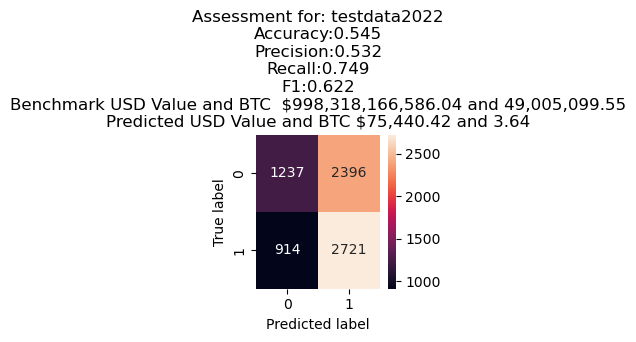

In [4]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

testdata2022 ='assets/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'

files= [testdata2022]
def binary(value):
  if value > 0:
    return 1
  else:
    return 0
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data


for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)
    prediction = (PredictDF.shift(-1)['Close'] >= PredictDF['Close'])
    prediction = prediction.iloc[:-1]
    PredictDF['Actual_Label'] = prediction.astype(int)
    PredictDF= PredictDF.dropna()
    
    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)

    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']




    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()
    
    feature_names_JMJ = ['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
        'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'JMJ_5HMoving_averages', 'Mkt Sentiment',
       'Crypto Sentiment', 'Historically Optimal SMA(s-t)',
       'Historically Optimal SMA(l-t)', 'Historically Optimal WMA(s-t)',
       'Historically Optimal WMA(l-t)', 'Historically Optimal EMA(s-t)',
       'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5']

    X_test = PredictDF[feature_names_JMJ]
    y_test = PredictDF['Actual_Label']

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_test)
    X_test_scaled = scaler.transform(X_test)

    predict_y=  Model2.predict(X_test_scaled)
    PredictDF['Predicted_Label']= predict_y

    print(classification_report(y_test, predict_y))   
    
    # confusion_mc = confusion_matrix(y_test_mc, svm_predicted_mc)
    confusion_mc = confusion_matrix(PredictDF['Actual_Label'], PredictDF['Predicted_Label'])
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,2)])


    PredictDF['ValueActual'] =0
    PredictDF['BTCValueActual'] =0
    if PredictDF.loc[PredictDF.index[0],'Actual_Label']==0.0:
        PredictDF.loc[PredictDF.index[0],'ValueActual']=100000
    else:
        PredictDF.loc[PredictDF.index[0],'BTCValueActual']=round((100000/PredictDF.loc[PredictDF.index[0],'Close']),5)


    for current in range(1, len(PredictDF.index)):
        previous = current - 1

        if PredictDF.loc[PredictDF.index[current],'Actual_Label']==0 and PredictDF.loc[PredictDF.index[previous],'BTCValueActual']==0:
            PredictDF.loc[PredictDF.index[current],'ValueActual']=PredictDF.loc[PredictDF.index[previous],'ValueActual']
        elif PredictDF.loc[PredictDF.index[current],'Actual_Label']==1 and PredictDF.loc[PredictDF.index[previous],'ValueActual'] ==0 :
            PredictDF.loc[PredictDF.index[current],'ValueActual']= 0
            PredictDF.loc[PredictDF.index[current],'BTCValueActual']=round(PredictDF.loc[PredictDF.index[previous],'BTCValueActual'],3)
        elif PredictDF.loc[PredictDF.index[current],'Actual_Label']==1:
            PredictDF.loc[PredictDF.index[current],'BTCValueActual'] = round((PredictDF.loc[PredictDF.index[previous],'ValueActual']/PredictDF.loc[PredictDF.index[current],'Close']),5)
        else:
            PredictDF.loc[PredictDF.index[current],'ValueActual'] = round((PredictDF.loc[PredictDF.index[previous],'BTCValueActual'] *PredictDF.loc[PredictDF.index[current],'Close']),3)


    PredictDF['ValuePredicted'] =0
    PredictDF['BTCValuePredicted'] =0
    if PredictDF.loc[PredictDF.index[0],'Predicted_Label']==0.0:
        PredictDF.loc[PredictDF.index[0],'ValuePredicted']=100000
    else:
        PredictDF.loc[PredictDF.index[0],'BTCValuePredicted']=round((100000/PredictDF.loc[PredictDF.index[0],'Close']),5)


    for current in range(1, len(PredictDF.index)):
        previous = current - 1

        if PredictDF.loc[PredictDF.index[current],'Predicted_Label']==0 and PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted']==0:
            PredictDF.loc[PredictDF.index[current],'ValuePredicted']=PredictDF.loc[PredictDF.index[previous],'ValuePredicted']
        elif PredictDF.loc[PredictDF.index[current],'Predicted_Label']==1 and PredictDF.loc[PredictDF.index[previous],'ValuePredicted'] ==0 :
            PredictDF.loc[PredictDF.index[current],'ValuePredicted']= 0
            PredictDF.loc[PredictDF.index[current],'BTCValuePredicted']=round(PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted'],3)
        elif PredictDF.loc[PredictDF.index[current],'Predicted_Label']==1:
            PredictDF.loc[PredictDF.index[current],'BTCValuePredicted'] = round((PredictDF.loc[PredictDF.index[previous],'ValuePredicted']/PredictDF.loc[PredictDF.index[current],'Close']),5)
        else:
            PredictDF.loc[PredictDF.index[current],'ValuePredicted'] = round((PredictDF.loc[PredictDF.index[previous],'BTCValuePredicted'] *PredictDF.loc[PredictDF.index[current],'Close']),3)
    df = PredictDF.mask(PredictDF==0).ffill().iloc[[-1]]
    LastPredictvalue = df['ValuePredicted'].values[0]
    LastPredictBTC = df['BTCValuePredicted'].values[0]
    # LastPredictvalue= PredictDF['ValuePredicted'][PredictDF['ValuePredicted'].to_numpy().nonzero()[0][-1]+1]
    # LastPredictBTC= PredictDF['BTCValuePredicted'][PredictDF['BTCValuePredicted'].to_numpy().nonzero()[0][-1]+1]

    #     print('Total USD Value and BTC Benchmark Actual Label: ${:,.2f} and {:,.2f} BTC'.format (max(PredictDF['ValueActual']),max(PredictDF['BTCValueActual'])))#, )       
    #     print('Total USD Value and BTC Benchmark Actual Label: ${:,.2f} and {:,.2f} BTC'.format (LastPredictvalue,LastPredictBTC))#, )       
    #     print (' ')


    plt.figure(figsize=(2,2))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Assessment for: {}\nAccuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}\nBenchmark USD Value and BTC  ${:,.2f} and {:,.2f}\nPredicted USD Value and BTC ${:,.2f} and {:,.2f}'.format(x, accuracy_score(PredictDF['Actual_Label'],PredictDF['Predicted_Label']),
                                                                        precision_score(PredictDF['Actual_Label'],PredictDF['Predicted_Label']),
                                                                                    recall_score(PredictDF['Actual_Label'], PredictDF['Predicted_Label']),
                                                                                    f1_score(PredictDF['Actual_Label'], PredictDF['Predicted_Label']),
                                                                                     max(PredictDF['ValueActual']),max(PredictDF['BTCValueActual']),
                                                                                     LastPredictvalue,LastPredictBTC
                                                                                    ))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
stacking_classifier

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=0.01, max_iter=1000)),
                               ('abc',
                                AdaBoostClassifier(learning_rate=0.001,
                                                   n_estimators=20)),
                               ('lda', LinearDiscriminantAnalysis()),
                               ('GBC',
                                GradientBoostingClassifier(learning_rate=0.01))],
                   final_estimator=GradientBoostingClassifier(learning_rate=0.01),
                   passthrough=True, stack_method='predict_proba')

## Trying with Thesholds

In [5]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

testdata2022 ='assets/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'

files= [testdata2022]

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

UpperThreshold = 0.6
LowerThresshold = 0.4

for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)
    prediction = (PredictDF.shift(-1)['Close'] >= PredictDF['Close'])
    prediction = prediction.iloc[:-1]
    PredictDF['Actual_Label'] = prediction.astype(int)
    PredictDF= PredictDF.dropna()
    
    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)

    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']




    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()
   
    feature_names_JMJ = ['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
        'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'JMJ_5HMoving_averages', 'Mkt Sentiment',
       'Crypto Sentiment', 'Historically Optimal SMA(s-t)',
       'Historically Optimal SMA(l-t)', 'Historically Optimal WMA(s-t)',
       'Historically Optimal WMA(l-t)', 'Historically Optimal EMA(s-t)',
       'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5']


    X_test = PredictDF[feature_names_JMJ]
    y_test = PredictDF['Actual_Label']

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_test)
    X_test_scaled = scaler.transform(X_test)

#     predict_y1= np.argmax(stacking_classifier.predict_proba(X_test_scaled),axis=0)
    predict_y=  Model2.predict_proba(X_test_scaled)[:,1]

    #PredictDF['Predicted_Label']= predict_y

#     print(classification_report(y_test, predict_y))   

    testy_predThreshold = np.where(predict_y > UpperThreshold, 1,np.where(predict_y < LowerThresshold, 0,2))
    testy_predThreshold = testy_predThreshold.squeeze()
    dataset = pd.DataFrame({'Y_TEST': y_test, 'Y_PREDICTED': testy_predThreshold}, columns=['Y_TEST', 'Y_PREDICTED'])
    dataset2 = dataset.drop(dataset[dataset.Y_PREDICTED == 2].index)
   
    try:
#         LTSMaccuracy = accuracy_score(dataset2['Y_TEST'].values, dataset2['Y_PREDICTED'].values)
#         LTSM_RESULTS.append(LTSMaccuracy)
    
#         # Print classification report
        print(classification_report(dataset2['Y_TEST'].values, dataset2['Y_PREDICTED'].values))
        print(confusion_matrix(dataset2['Y_TEST'].values, dataset2['Y_PREDICTED'].values))
    except:
        print("No values")
    


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        24
         1.0       0.57      1.00      0.73        32

    accuracy                           0.57        56
   macro avg       0.29      0.50      0.36        56
weighted avg       0.33      0.57      0.42        56

[[ 0 24]
 [ 0 32]]


C:\Users\mario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Exporting Predictions

In [26]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


testdata2022 ='assets/newfeatures/TEST_MergeJMJPCHourly2019202_NewsGoogleApi_ActualLabel.csv'

files= [testdata2022]

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    return data

UpperThreshold = 0.5
LowerThresshold = 0.5

for file,x in zip(files, ['testdata2022']):
    PredictDF= pd.read_csv(file)
    prediction = (PredictDF.shift(-1)['Close'] >= PredictDF['Close'])
    prediction = prediction.iloc[:-1]
    PredictDF['Actual_Label'] = prediction.astype(int)
    PredictDF= PredictDF.dropna()
    
    Indicatordata = _exponential_smooth(PredictDF[['Close', 'Open','High','Low','Volume']], 0.65)

    Indicatordatafinal = _get_indicator_data(Indicatordata)

    Indicatordatafinal = Indicatordatafinal.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis = 1)
    PredictDF = pd.merge(PredictDF, Indicatordatafinal, left_index=True, right_index=True)
    PredictDF = PredictDF.drop(['time','hour','Open Time','_merge','Signal','Position', 'Signal35JMJ', 'Position35JMJ', 'Ignore'], axis = 1)

    
    
    
    
    columns = ['favorites', 'retweets', 'number_of_followers', 'following',
           'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
           'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open', 'High',
           'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades',
           'TB Base Volume', 'TB Quote Volume', '3MovingAverage', '5MovingAverage',
           'JMJ_3HMoving_averages', 'JMJ_5HMoving_averages', 
           '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
           '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
           '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5']




    for column in columns: 
        PredictDF['Binary{}'.format(column)]  = (PredictDF[column] - PredictDF[column].shift(1)).apply(binary)
    

    PredictDF = PredictDF.dropna()
    
    feature_names_JMJ = ['favorites', 'retweets', 'number_of_followers', 'following',
       'followers_following_ratio', '2x_retweets_+_favorites', 'polarity',
       'W1 Score', 'Bull_ratio', 'W Score With Bull Ratio', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'TB Base Volume', 'TB Quote Volume',
       '3MovingAverage', '5MovingAverage', 'JMJ_3HMoving_averages',
        'Bitcoin_Google_Trend_Score', 'BTC_Google_Trend_Score',
       'JMJ_5HMoving_averages', 'Mkt Sentiment',
       'Crypto Sentiment', 'Historically Optimal SMA(s-t)',
       'Historically Optimal SMA(l-t)', 'Historically Optimal WMA(s-t)',
       'Historically Optimal WMA(l-t)', 'Historically Optimal EMA(s-t)',
       'Historically Optimal EMA(l-t)',
       'Twitter Hourly Favorites SMA(s-t)',
       'Twitter Hourly Favorites SMA(l-t)',
       'Twitter Hourly Favorites WMA(s-t)',
       'Twitter Hourly Favorites WMA(l-t)',
       'Twitter Hourly Favorites EMA(s-t)',
       'Twitter Hourly Favorites EMA(l-t)',
       'Twitter Hourly Retweets SMA(s-t)',
       'Twitter Hourly Retweets SMA(l-t)',
       'Twitter Hourly Retweets WMA(s-t)',
       'Twitter Hourly Retweets WMA(l-t)',
       'Twitter Hourly Retweets EMA(s-t)',
       'Twitter Hourly Retweets EMA(l-t)',
       'Twitter Hourly Follower Exposure SMA(s-t)',
       'Twitter Hourly Follower Exposure SMA(l-t)',
       'Twitter Hourly Follower Exposure WMA(s-t)',
       'Twitter Hourly Follower Exposure WMA(l-t)',
       'Twitter Hourly Follower Exposure EMA(s-t)',
       'Twitter Hourly Follower Exposure EMA(l-t)',
       'Twitter Hourly Following Exposure SMA(s-t)',
       'Twitter Hourly Following Exposure SMA(l-t)',
       'Twitter Hourly Following Exposure WMA(s-t)',
       'Twitter Hourly Following Exposure WMA(l-t)',
       'Twitter Hourly Following Exposure EMA(s-t)',
       'Twitter Hourly Following Exposure EMA(l-t)',
       'Twitter Hourly Follower to Following Ratio SMA(s-t)',
       'Twitter Hourly Follower to Following Ratio SMA(l-t)',
       'Twitter Hourly Follower to Following Ratio WMA(s-t)',
       'Twitter Hourly Follower to Following Ratio WMA(l-t)',
       'Twitter Hourly Follower to Following Ratio EMA(s-t)',
       'Twitter Hourly Follower to Following Ratio EMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites SMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites WMA(l-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(s-t)',
       'Twitter Hourly 2x Retweets + Favorites EMA(l-t)',
       'Twitter Hourly Polarity Score SMA(s-t)',
       'Twitter Hourly Polarity Score SMA(l-t)',
       'Twitter Hourly Polarity Score WMA(s-t)',
       'Twitter Hourly Polarity Score WMA(l-t)',
       'Twitter Hourly Polarity Score EMA(s-t)',
       'Twitter Hourly Polarity Score EMA(l-t)',
       'Twitter W1 Score SMA(s-t)', 'Twitter W1 Score SMA(l-t)',
       'Twitter W1 Score WMA(s-t)', 'Twitter W1 Score WMA(l-t)',
       'Twitter W1 Score EMA(s-t)', 'Twitter W1 Score EMA(l-t)',
       'Twitter Hourly Bull Ratio SMA(s-t)',
       'Twitter Hourly Bull Ratio SMA(l-t)',
       'Twitter Hourly Bull Ratio WMA(s-t)',
       'Twitter Hourly Bull Ratio WMA(l-t)',
       'Twitter Hourly Bull Ratio EMA(s-t)',
       'Twitter Hourly Bull Ratio EMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio SMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio WMA(l-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(s-t)',
       'Twitter Hourly Weighted Bull Ratio EMA(l-t)',
       'Quote Asset Volume SMA(s-t)', 'Quote Asset Volume SMA(l-t)',
       'Quote Asset Volume WMA(s-t)', 'Quote Asset Volume WMA(l-t)',
       'Quote Asset Volume EMA(s-t)', 'Quote Asset Volume EMA(l-t)',
       '# of Hourly Trades SMA(s-t)', '# of Hourly Trades SMA(l-t)',
       '# of Hourly Trades WMA(s-t)', '# of Hourly Trades WMA(l-t)',
       '# of Hourly Trades EMA(s-t)', '# of Hourly Trades EMA(l-t)',
       'TB Base Volume SMA(s-t)', 'TB Base Volume SMA(l-t)',
       'TB Base Volume WMA(s-t)', 'TB Base Volume WMA(l-t)',
       'TB Base Volume EMA(s-t)', 'TB Base Volume EMA(l-t)',
       'TB Quote Volume SMA(s-t)', 'TB Quote Volume SMA(l-t)',
       'TB Quote Volume WMA(s-t)', 'TB Quote Volume WMA(l-t)',
       'TB Quote Volume EMA(s-t)', 'TB Quote Volume EMA(l-t)',
       '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol', 'Binaryfavorites', 'Binaryretweets',
       'Binarynumber_of_followers', 'Binaryfollowing',
       'Binaryfollowers_following_ratio', 'Binary2x_retweets_+_favorites',
       'Binarypolarity', 'BinaryW1 Score', 'BinaryBull_ratio',
       'BinaryW Score With Bull Ratio', 'BinaryOpen', 'BinaryHigh',
       'BinaryLow', 'BinaryClose', 'BinaryVolume',
       'BinaryQuote Asset Volume', 'BinaryNumber of Trades',
       'BinaryTB Base Volume', 'BinaryTB Quote Volume',
       'Binary3MovingAverage', 'Binary5MovingAverage',
       'BinaryJMJ_3HMoving_averages', 'BinaryJMJ_5HMoving_averages',
       'Binary14 period RSI', 'BinaryMACD', 'BinarySIGNAL',
       'Binary14 period STOCH %K', 'BinaryMFV', 'Binary14 period ATR',
       'BinaryMOM', 'Binary14 period MFI', 'BinaryROC', 'BinaryOBV',
       'Binary20 period CCI', 'Binary14 period EMV', 'BinaryVIm',
       'BinaryVIp', 'Binaryema50', 'Binaryema21', 'Binaryema15',
       'Binaryema5']


    X_test = PredictDF[feature_names_JMJ]
    y_test = PredictDF['Actual_Label']

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_test)
    X_test_scaled = scaler.transform(X_test)

#     predict_y1= np.argmax(stacking_classifier.predict_proba(X_test_scaled),axis=0)
    #predict_y=  Model2.predict_proba(X_test_scaled)[:,1]

    PredictDF['Prediction']= Model2.predict_proba(X_test_scaled)[:,1]


In [27]:
PredictDF

,favorites,retweets,number_of_followers,following,followers_following_ratio,2x_retweets_+_favorites,polarity,W1 Score,Bull_ratio,W Score With Bull Ratio,...,BinaryOBV,Binary20 period CCI,Binary14 period EMV,BinaryVIm,BinaryVIp,Binaryema50,Binaryema21,Binaryema15,Binaryema5,Prediction
14,9.797619,0.745238,16514.150000,1498.323810,63.299076,11.288095,0.113520,0.128081,4.256410,0.545164,...,0,1,0,0,0,0,0,0,0,0.597851
15,39.326190,3.390476,16099.623810,1672.185714,110.504489,46.107143,0.087327,0.253405,2.500000,0.633513,...,0,0,0,1,0,0,0,0,0,0.554832
16,5.369048,0.550000,11057.442857,1828.021429,133.780075,6.469048,0.093584,0.222649,2.450000,0.545491,...,0,1,0,1,0,0,0,0,1,0.554832
17,14.495238,1.890476,25029.171429,1882.980952,662.631886,18.276190,0.090903,0.173174,2.500000,0.432936,...,1,1,1,0,1,1,1,1,1,0.540372
18,13.329545,1.281818,22107.427273,2018.227273,479.791704,15.893182,0.095774,0.263250,3.395833,0.893952,...,1,1,1,0,1,1,1,1,1,0.490305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,10.030952,2.557143,12561.900000,906.071429,406.088057,15.145238,0.094200,0.365355,3.066667,1.120422,...,1,1,1,0,1,1,1,1,1,0.536587
7264,9.507143,3.530952,10695.850000,805.514286,264.229345,16.569048,0.075146,0.250643,2.518519,0.631248,...,0,1,1,0,1,0,0,0,1,0.551489
7265,17.957143,4.402381,22596.990476,846.535714,217.348828,26.761905,0.104180,0.403896,2.941176,1.187930,...,0,0,0,1,1,0,1,1,1,0.551489
7266,4.788095,1.021429,21378.707143,730.971429,172.471290,6.830952,0.097456,0.310215,4.176471,1.295602,...,1,1,0,1,0,1,1,1,1,0.503589


In [28]:
PredictDF.to_csv('predictions/StackingPrediction_LR_ABC_LDA_GBC_to_GBC.csv')